## generating the dataset
we generate {X, y} from scratch. $X$ is a ndim array of features. $y$ is the corresponding target, and equals XOR of $X_1$ and $X_2$ (ie $y$ is true if either $X_1$ or $X_2$ is true, otherwise it is false). all other features in $X$ is random uniform noise.

## which features should the attention vector attend to?
since $y$ is XOR of $X_1$ and $X_2$, we would expect the attention vector to attend to both $X_1$ and $X_2$. (knowing either $X_1$ and $X_2$ is insufficient.)

moreover, since all other features in $X$ is random noise - and therefore are uninformative features - we would expect attention vector to ignore all other features.

In [1]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

torch.set_default_dtype(torch.float64)

In [2]:
# generate data from scratch
n_samples = 10000
n_features = 16

# attention vector has n_hidden dim, which must equal input ndim since it masks inputs
n_hidden = n_features

X = np.random.uniform(low=-5, high=5, size=(n_samples, n_features))

In [3]:
# set X1 and X2 to either 0 or 1
X[:, 0] = X[:, 0] > 0  # feature 0
X[:, 1] = X[:, 1] > 0  # feature 1

In [4]:
# generate corresponding target y data
y = np.logical_xor(X[:, 0], X[:, 1]) * 1  # y = XOR(X1, X2)

n_classes = 2
y = np.eye(n_classes)[y]  # convert y to one-hot encoding

In [5]:
X[:5, 0]
X[:5, 1]
y[:5]

array([1., 0., 0., 1., 1.])

array([0., 1., 1., 1., 1.])

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [6]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [7]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x, y):     
        for each in self.hidden_layers:
            z = F.softmax(each(x))
            x = torch.mul(z, x)
        #x = self.output(x)
        return self.output(x)
    
    def att_vector(self, x, y):
        for each in self.hidden_layers:
            z = F.softmax(each(x))
        return z


In [8]:
model = Network(n_features, n_classes, [n_hidden])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
def train(model, inputs, labels, criterion, optimizer, epochs, batch_size, print_every):
    steps = 0
    running_loss = 0
    
    for e in range(epochs):
        model.train()
        
        mb_indices = np.random.choice(X.shape[0], batch_size)
        
        X_train = X[mb_indices]
        y_train = y[mb_indices]
        
        optimizer.zero_grad()

        output = model.forward(X_train, y_train)
        #print(output.size(), y_train.size())
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if e%print_every == 0:
            model.eval()

            print("Epoch: {}/{}.. ".format(e, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every))
                
            running_loss = 0
            model.train()

In [10]:
train(model, X, y, criterion, optimizer, 5000, 64, 500)

/home/q1park/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch: 0/5000..  Training Loss: 0.001.. 
Epoch: 500/5000..  Training Loss: 0.419.. 
Epoch: 1000/5000..  Training Loss: 0.077.. 
Epoch: 1500/5000..  Training Loss: 0.042.. 
Epoch: 2000/5000..  Training Loss: 0.029.. 
Epoch: 2500/5000..  Training Loss: 0.021.. 
Epoch: 3000/5000..  Training Loss: 0.018.. 
Epoch: 3500/5000..  Training Loss: 0.014.. 
Epoch: 4000/5000..  Training Loss: 0.013.. 
Epoch: 4500/5000..  Training Loss: 0.013.. 


In [13]:
attention_vector = model.att_vector(X, y)
np.mean(attention_vector.detach().numpy(), axis=0) 

/home/q1park/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([3.04527778e-01, 2.54949094e-01, 4.40589143e-02, 3.79840961e-02,
       2.77683146e-02, 4.98704459e-03, 1.95136788e-02, 4.71203965e-02,
       4.11730033e-02, 1.55679578e-05, 4.61321854e-02, 4.44755407e-02,
       2.72620119e-02, 5.23196867e-02, 2.26416478e-02, 2.50710391e-02])

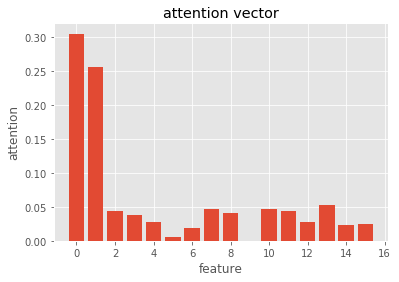

In [14]:
# which features should we attend to?
plt.bar(x = np.arange(n_features), height = np.mean(attention_vector.detach().numpy(), axis=0));
plt.xlabel("feature");
plt.ylabel("attention");
plt.title("attention vector");